<a href="https://colab.research.google.com/github/1Un/MNIST/blob/master/Simple_cnn_mnist_lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [0]:
import torch
import random
import numpy as np
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


In [6]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
len(y_train), len(y_test)

(60000, 10000)

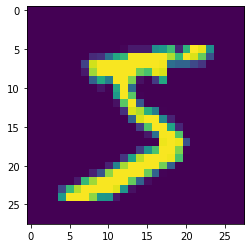

tensor(5)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train.shape


torch.Size([60000, 28, 28])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [11]:
X_train.shape
# отличие от полносвязанной сети, которая видела картинку как один вектор длинный,
# мы хотим в конволюционную сеть передавать картинку как трёхмерный тензор.
# Первый канал -- это глубина картинки, в черно-белой картинке это 1
# канал с яркостью серого пикселя. А в RGB картинке будут RGB каналы.
# Соответственно, мы должны нашу картинку, которая на вход пришла (она просто "28 на 28"),
# разжать до "1 на 28 на 28". Вот мы это и делаем -- мы делаем X_train.unsqueeze,
# а здесь ставим индекс: "а в каком же измерении мы хотим разжать".
# То есть X_train у нас -- тензор из 60 000 картинок 28 на 28,
# а мы хотим чтобы было 60 000 на 1 на 28 на 28, и то же самое мы делаем с тестом.

torch.Size([60000, 1, 28, 28])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,neurons):
        super(LeNet5, self).__init__()
        #conv 2d называется так как матрица у нас двумерная  
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=8, kernel_size=5, padding=0)#16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        #изображение в 1 вектор растянем в forward а пока в конструкторе прдеставим что это уже сделано
        self.fc1   = torch.nn.Linear(5 * 5 *8,10) #16, neurons)
        #self.act3  = torch.nn.Tanh()
        
        # self.fc2   = torch.nn.Linear(neurons, neurons-36)
        # self.act4  = torch.nn.Tanh()
        
        #self.fc3   = torch.nn.Linear(neurons, 10)
    
    #x - входной тензор, т.е. батч из картинок 
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        #преобразуем наш тенхор к нужной размерности x.size(0) - размер батча 
        #а дальше тензор одномерный очевидно что бы получить этот размер надо
        #просто перемножить 3 размерности
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        #x = self.act3(x)
        # x = self.fc2(x)
        # x = self.act4(x)
        #x = self.fc3(x)
        
        return x
    


In [0]:
# def sum_par(model):
#   s=0
#   for i in model.parameters():
#     #print(i)
#     print(len(i.reshape(-1)))
#     s+=len(i.reshape(-1))
#   return s
# print('sum=',sum_par(lenet5))
#========

# lenet5= LeNet5()
# import torchsummary
# print("Все параметры сети:")
# torchsummary.summary(lenet5.cuda(),(1,28,28))
# #(1,28,28) - размер входного изображения 


def study(lenet5,X_test,y_test,X_train,y_train,batch_size = 5000):  
  #!nvidia-smi
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  lenet5 = lenet5.to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
  

  test_accuracy_history = []
  test_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  for epoch in range(100):
      order = np.random.permutation(len(X_train))
      for start_index in range(0, len(X_train), batch_size):
          optimizer.zero_grad()
          
          batch_indexes = order[start_index:start_index+batch_size]
          
          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)
          
          preds = lenet5.forward(X_batch) 
          
          loss_value = loss(preds, y_batch)
          loss_value.backward()
          
          optimizer.step()
          
      test_preds = lenet5.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test).data.cpu())

      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)

      if epoch%5==0:
        print('epoch=',epoch,'\taccuracy=',accuracy)
  return test_loss_history,test_accuracy_history
      

In [21]:
test_loss_history=[]
test_accuracy_history=[]
!nvidia-smi
#for i in range(64,9,-2):
lenet5= LeNet5(10)#i)  
import torchsummary
print("Все параметры сети:")
torchsummary.summary(lenet5.cuda(),(1,28,28))
#print('=====',i,'=====')
test_loss_history1,test_accuracy_history1=study(lenet5,X_test,y_test,X_train,y_train,batch_size = 5000)
test_loss_history.append(test_loss_history1)
test_accuracy_history.append(test_accuracy_history1)

Mon Apr 27 12:20:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    73W / 149W |   2852MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np

In [0]:
test_loss_history_np=np.array(test_loss_history)
test_accuracy_history_np=np.array(test_accuracy_history)


In [33]:
print(test_loss_history_np)
print(test_accuracy_history_np)

[[1.9965297  1.5980684  1.1743057  0.85666454 0.6674228  0.5570169
  0.4869357  0.43756363 0.39982057 0.3693027  0.3429586  0.31923807
  0.2986522  0.2793665  0.26169044 0.24601287 0.23142512 0.21847275
  0.20694277 0.19670077 0.18731767 0.17900613 0.17151166 0.16499826
  0.1588073  0.15299325 0.14821607 0.14377701 0.13893253 0.13501392
  0.1312186  0.12745267 0.12435436 0.12082998 0.11827389 0.1156081
  0.11278231 0.11049402 0.10778438 0.10538712 0.10350092 0.10149305
  0.09998138 0.09784643 0.09599137 0.09434916 0.09277213 0.09125224
  0.08969278 0.08819261 0.08722892 0.08561233 0.08438104 0.08323194
  0.08207174 0.0810001  0.07983124 0.078663   0.07723936 0.07693706
  0.07562406 0.07481543 0.07381725 0.07300068 0.0720094  0.0715
  0.07061289 0.06976297 0.06918588 0.06870348 0.06791805 0.06743623
  0.06658043 0.06625859 0.06520944 0.06465249 0.06408284 0.06333098
  0.06305362 0.06278949 0.06191652 0.06182234 0.06153835 0.06084134
  0.0603593  0.05969079 0.05937456 0.05899372 0.058945

In [24]:
x1=np.copy(test_loss_history_np)
x2=np.copy(test_accuracy_history_np)
#показание лосс функции на последней эпохе
print(test_loss_history_np[:,-1])



[0.05530958]


In [25]:
#точность предсказания на последней эпохе 
print(test_accuracy_history_np[:,-1])

[0.9837]


In [0]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
# save to csv file
savetxt('min_test_loss_history_np.csv', test_loss_history_np, delimiter=',')
savetxt('min_test_accuracy_history_np.csv', test_accuracy_history_np, delimiter=',')

# load numpy array from csv file
# from numpy import loadtxt
# # load array
# test_loss_history_np = loadtxt('./test_loss_history_np.csv', delimiter=',')
# test_accuracy_history_np = loadtxt('./test_accuracy_history_np.csv', delimiter=',')

In [0]:
# from numpy import genfromtxt
# test_accuracy_history_np = genfromtxt('/content/120-64_test_accuracy_history_np.csv', delimiter=',')
# test_loss_history_np = genfromtxt('/content/120-64_test_loss_history_np.csv', delimiter=',')

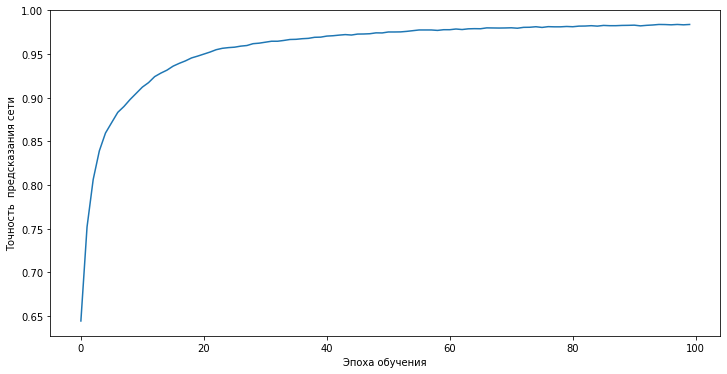

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test_accuracy_history_np[0])  

#plt.gca().invert_xaxis()

ax.set_xlabel('Эпоха обучения')

ax.set_ylabel('Точность  предсказания сети')
#plt.show()
plt.savefig('7.png')

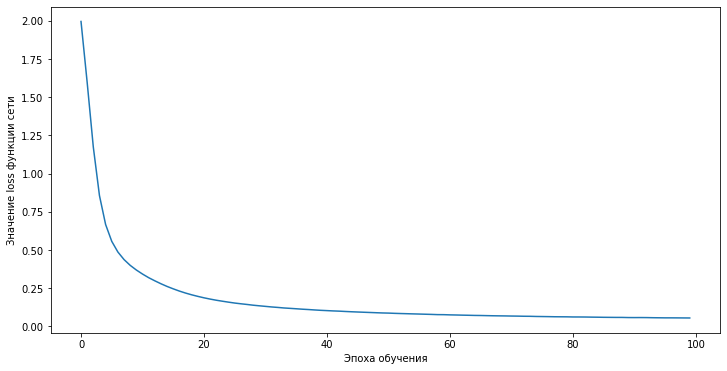

In [39]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test_loss_history_np[0])  

#plt.gca().invert_xaxis()

ax.set_xlabel('Эпоха обучения')

ax.set_ylabel('Значение loss функции сети')
plt.savefig('8.png')